## PART_1 TRAIN MODEL WITH TRANSFER LEARNING

In this notebook , we will :

    * train a model with transfer learning
    * use this model for prediction
    * most importantly, we will see ' what our model see'

In [1]:
#Keras Model Visualization

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import *
from keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
batchsize = 10
NUM_EPOCHS = 10
#img_width, img_height = 150, 150
#for VGG 16 use 224 image size
img_width, img_height = 224, 224

In [3]:
main_path=os.getcwd()

In [4]:
train_dir = 'furniture_images/img/train'
val_dir = 'furniture_images/img/val'

train_bed_dir = os.path.join(train_dir, 'bed') 
train_chair_dir = os.path.join(train_dir, 'chair')  
train_sofa_dir = os.path.join(train_dir, 'sofa') 
val_bed_dir = os.path.join(val_dir, 'bed')  
val_chair_dir = os.path.join(val_dir, 'chair')  
val_sofa_dir = os.path.join(val_dir, 'sofa')  


In [5]:
train_bed_dir

'furniture_images/img/train\\bed'

In [6]:
num_bed_train = len(os.listdir(train_bed_dir))

In [7]:
num_bed_train

900

To create our dataset for training, we will use 3 furniture classes and split them for train and validation

In [8]:
num_bed_train = len(os.listdir(train_bed_dir))
num_chair_train = len(os.listdir(train_chair_dir))
num_sofa_train = len(os.listdir(train_sofa_dir))

num_bed_val = len(os.listdir(val_bed_dir))
num_chair_val = len(os.listdir(val_chair_dir))
num_sofa_val = len(os.listdir(val_sofa_dir))

num_train_images = num_bed_train + num_chair_train + num_sofa_train
num_val_images = num_bed_val + num_chair_val + num_sofa_val
print(num_train_images, num_val_images)

2700 300


For a better performance, we will use ImageDataGenerator()

In [9]:
train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batchsize)

Found 2700 images belonging to 3 classes.


In [10]:
len(train_generator)

270

In [15]:
len(train_generator[0])

2

In [17]:
train_generator[0][1]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [16]:
train_generator[0][0].shape

(10, 224, 224, 3)

!!!!  As you can see , after ImageDataGenerator we collect 10 images in a bundle with their labels(which is encoded for training) by the help of flow_from_directory()  !!! 

In [18]:
val_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batchsize)

Found 300 images belonging to 3 classes.


In [19]:
len(val_generator)

30

In [20]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [21]:
#BUILD VGG - SKIP CUSTOM MODEL STEP IF YOU USE VGG
base_model = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape=(img_height, img_width, 3))

In [22]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [23]:
base_model.layers

In [27]:
#BUILD VGG 
def build_final_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    
    
    x = GlobalAveragePooling2D()(x)
   
    x = Flatten()(x)
    
    
    # Fine-tune from this layer onwards
    fine_tune_at = 100

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable =  False
        print('One of the untrainable layer {}'.format(layer))

    
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    final_model = Model(inputs=base_model.input, outputs=predictions)

    return final_model




In [28]:
class_list = ["bed", "chair", "sofa"]
FC_LAYERS = [1024, 1024]
dropout = 0.3

model = build_final_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

One of the untrainable layer <keras.engine.input_layer.InputLayer object at 0x000002B716EFCD00>
One of the untrainable layer <keras.layers.convolutional.Conv2D object at 0x000002B7176B8760>
One of the untrainable layer <keras.layers.convolutional.Conv2D object at 0x000002B7176B8E20>
One of the untrainable layer <keras.layers.pooling.MaxPooling2D object at 0x000002B7176B8D90>
One of the untrainable layer <keras.layers.convolutional.Conv2D object at 0x000002B71DA9C1F0>
One of the untrainable layer <keras.layers.convolutional.Conv2D object at 0x000002B71DAAAE50>
One of the untrainable layer <keras.layers.pooling.MaxPooling2D object at 0x000002B71DAAAA90>
One of the untrainable layer <keras.layers.convolutional.Conv2D object at 0x000002B71DAAF520>
One of the untrainable layer <keras.layers.convolutional.Conv2D object at 0x000002B71DAB3850>
One of the untrainable layer <keras.layers.convolutional.Conv2D object at 0x000002B71DAAF2B0>
One of the untrainable layer <keras.layers.pooling.MaxPool

We freeze all CNN layers before the fully connected layers. It means 'we will just train our dense layers' , which will save lots of time

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:
#APPLICABLE FOR VGG & INCEPTION
adam = Adam(lr=0.00001)
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
history = model.fit(train_generator,epochs=NUM_EPOCHS,steps_per_epoch=num_train_images // batchsize,validation_data=val_generator, validation_steps=num_val_images // batchsize)

Epoch 1/10
270/270 [==============================] - 56s 171ms/step - loss: 1.8344 - accuracy: 0.4944 - val_loss: 0.6392 - val_accuracy: 0.7533
Epoch 2/10
270/270 [==============================] - 37s 136ms/step - loss: 0.9658 - accuracy: 0.6774 - val_loss: 0.5085 - val_accuracy: 0.8267
Epoch 3/10
270/270 [==============================] - 37s 138ms/step - loss: 0.7883 - accuracy: 0.7474 - val_loss: 0.4802 - val_accuracy: 0.8633
Epoch 4/10
270/270 [==============================] - 38s 140ms/step - loss: 0.6839 - accuracy: 0.7796 - val_loss: 0.5082 - val_accuracy: 0.8433
Epoch 5/10
270/270 [==============================] - 37s 136ms/step - loss: 0.6127 - accuracy: 0.8081 - val_loss: 0.4426 - val_accuracy: 0.8167
Epoch 6/10
270/270 [==============================] - 39s 144ms/step - loss: 0.5474 - accuracy: 0.8307 - val_loss: 0.4466 - val_accuracy: 0.8233
Epoch 7/10
270/270 [==============================] - 37s 138ms/step - loss: 0.5094 - accuracy: 0.8330 - val_loss: 0.3804 - val_ac

In [31]:
print(len(model.layers))

26


In [ ]:
model.save('vggonfurniture.hdf5')

## PART 2 _ SHOW WHAT MODEL SEE

In [32]:
loaded_model = load_model('vggonfurniture.hdf5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


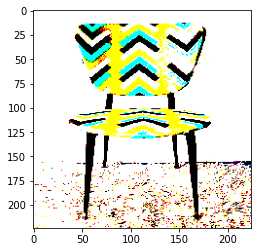

In [33]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

img_path = r'00000800.jpg'
#img_path = 'furniture_images/test/bed/00000876trainbed.jpg'
#img_path = 'furniture_images/test/sofa/00000803testsofa.jpg'
img = image.load_img(img_path, target_size=(img_height, img_width))
img_tensor_1 = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor_1, axis=0)
img_tensor = preprocess_input(img_tensor)

featuremap = loaded_model.predict(img_tensor)
plt.imshow(featuremap)
plt.imshow(img_tensor[0])
print (img_tensor.shape)

In [34]:
featuremap

array([[3.0681013e-06, 9.9999678e-01, 1.0740809e-07]], dtype=float32)

As you can see the model, the probability of the second class is really high. And it is chair and correct prediction

In [35]:
img_tensor[0]

array([[[73.061    , 59.221    , 54.32     ],
        [74.061    , 60.221    , 55.32     ],
        [75.061    , 61.221    , 56.32     ],
        ...,
        [44.060997 , 33.221    , 26.32     ],
        [39.060997 , 31.221    , 23.32     ],
        [37.060997 , 29.221    , 21.32     ]],

       [[76.061    , 62.221    , 57.32     ],
        [77.061    , 63.221    , 58.32     ],
        [77.061    , 63.221    , 58.32     ],
        ...,
        [45.060997 , 34.221    , 27.32     ],
        [39.060997 , 31.221    , 23.32     ],
        [37.060997 , 29.221    , 21.32     ]],

       [[79.061    , 65.221    , 60.32     ],
        [80.061    , 66.221    , 61.32     ],
        [81.061    , 67.221    , 62.32     ],
        ...,
        [47.060997 , 36.221    , 29.32     ],
        [42.060997 , 34.221    , 26.32     ],
        [39.060997 , 31.221    , 23.32     ]],

       ...,

       [[93.061    , 57.221    , 48.32     ],
        [92.061    , 60.221    , 50.32     ],
        [50.060997 , 2

In [39]:
img_tensor_1

array([[[54.32     , 59.221    , 73.061    ],
        [55.32     , 60.221    , 74.061    ],
        [56.32     , 61.221    , 75.061    ],
        ...,
        [26.32     , 33.221    , 44.060997 ],
        [23.32     , 31.221    , 39.060997 ],
        [21.32     , 29.221    , 37.060997 ]],

       [[57.32     , 62.221    , 76.061    ],
        [58.32     , 63.221    , 77.061    ],
        [58.32     , 63.221    , 77.061    ],
        ...,
        [27.32     , 34.221    , 45.060997 ],
        [23.32     , 31.221    , 39.060997 ],
        [21.32     , 29.221    , 37.060997 ]],

       [[60.32     , 65.221    , 79.061    ],
        [61.32     , 66.221    , 80.061    ],
        [62.32     , 67.221    , 81.061    ],
        ...,
        [29.32     , 36.221    , 47.060997 ],
        [26.32     , 34.221    , 42.060997 ],
        [23.32     , 31.221    , 39.060997 ]],

       ...,

       [[48.32     , 57.221    , 93.061    ],
        [50.32     , 60.221    , 92.061    ],
        [15.32     , 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


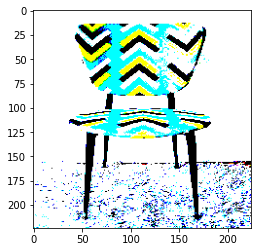

In [37]:
plt.imshow(img_tensor_1)

### I printed both of image array to show 'what preprocess commend make' 

To show layers output, we need to define a new model and assign all layers as output to check what they have

In [41]:
layer_outputs = [layer.output for layer in model.layers[:len(model.layers)]]
activation_modelfig = Model(inputs=model.input, outputs=layer_outputs)


In [42]:
activation_modelfig.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

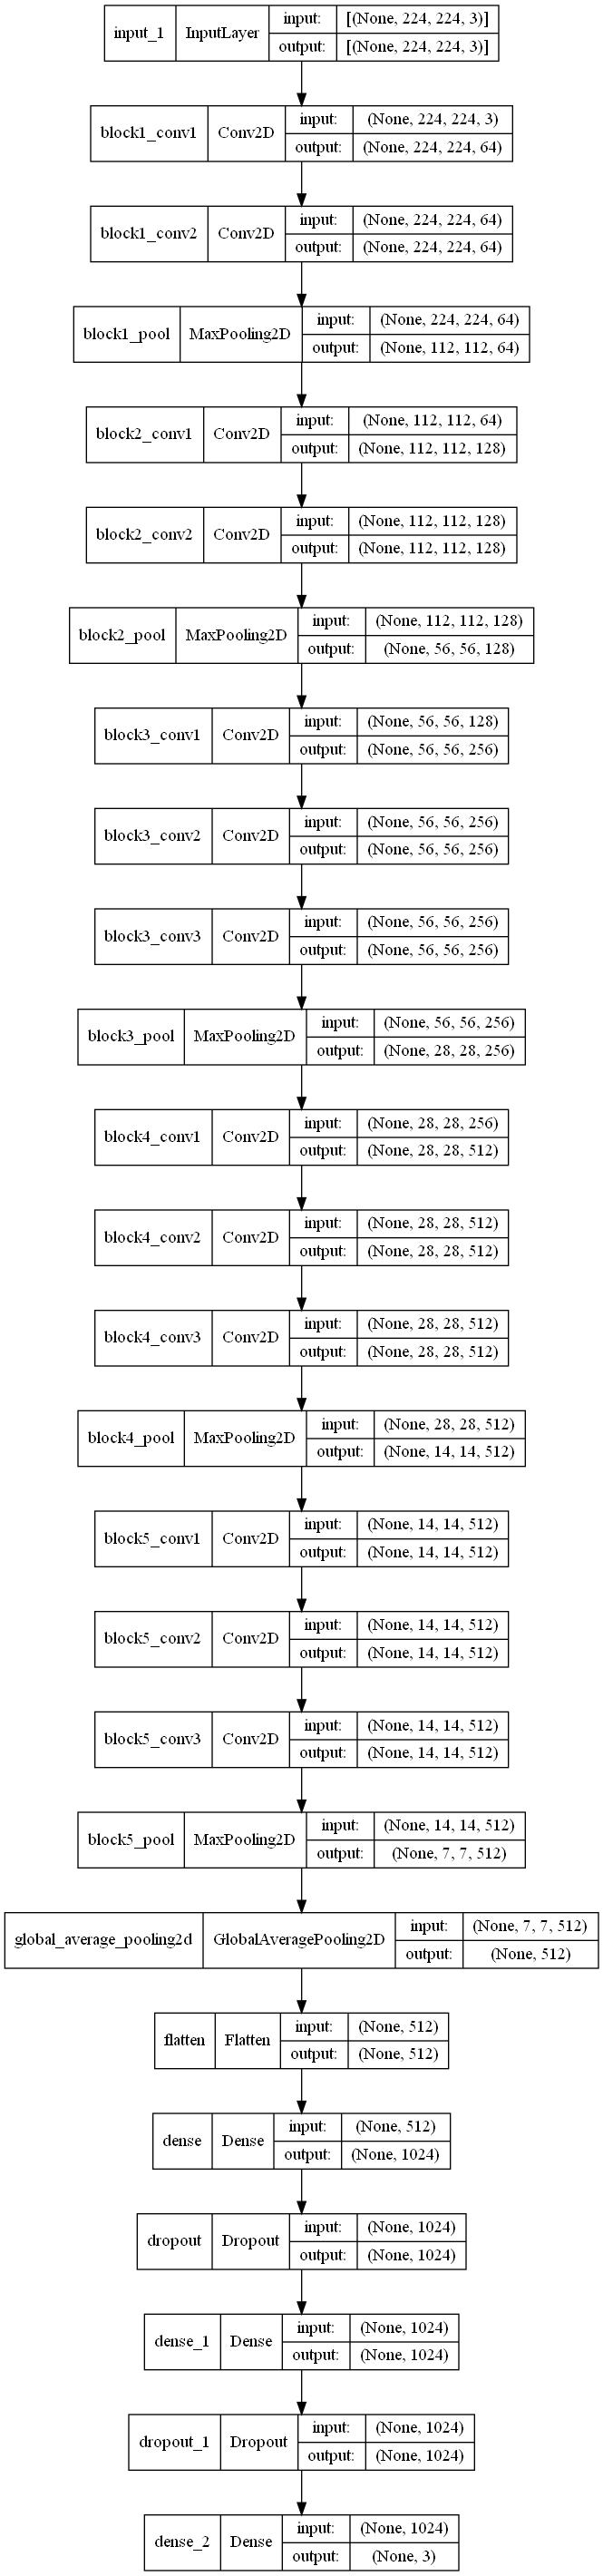

In [43]:
from tensorflow.keras.utils import plot_model
from PIL import Image
plot_model(activation_modelfig, show_shapes=True, show_layer_names=True, to_file='to_see_layermodel.jpg')

In [44]:
activationsfig = activation_modelfig.predict(img_tensor)

In [45]:
len(activationsfig)

26

We have 26 outputs, one for each layers.. Let's see what are they

In [46]:
first_layer_activation = activationsfig[0]

In [47]:
first_layer_activation.shape

(1, 224, 224, 3)

In [48]:
second_layer_activation=activationsfig[1]

In [49]:
second_layer_activation.shape

(1, 224, 224, 64)

first CON2D layer's output shape is 64 as we can see from the model summary

In [53]:
second_layer_activation[0].shape

(224, 224, 64)

In [55]:
second_layer_activation[0][:,:,3].shape

(224, 224)

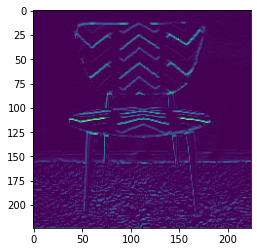

In [56]:
plt.imshow(second_layer_activation[0][:,:,3])

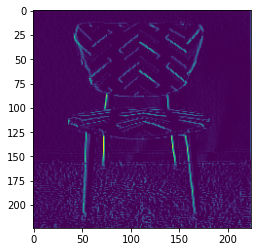

In [57]:
plt.imshow(second_layer_activation[0][:,:,63])

FOR EACH LAYERS, WE TAKE FIRST,MID AND LAST KERNEL TO SHOW... YOU CAN SEE THE RESULTS BELOW.

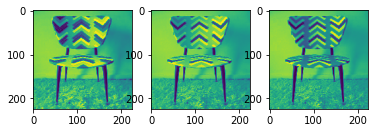

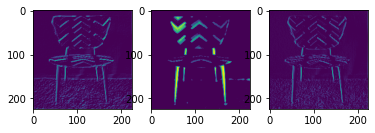

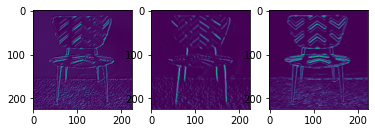

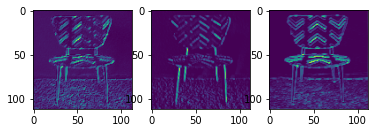

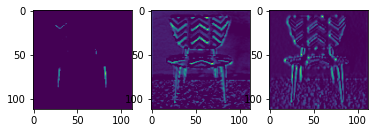

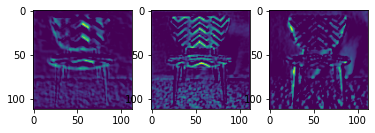

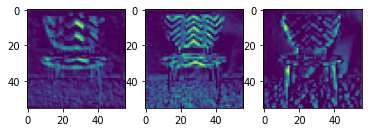

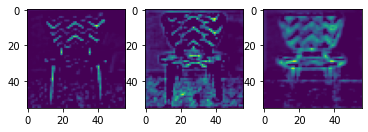

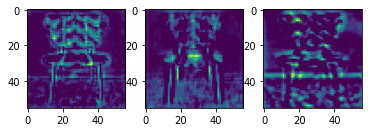

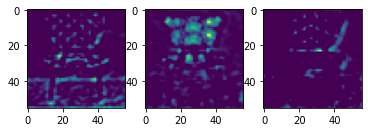

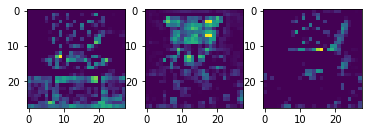

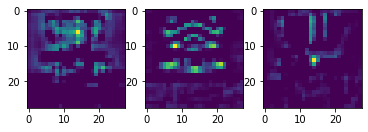

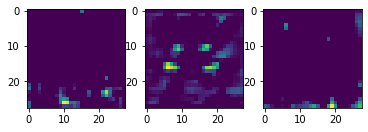

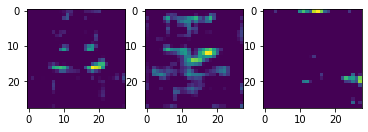

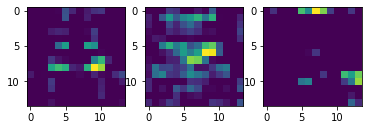

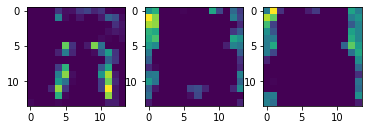

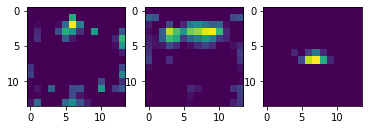

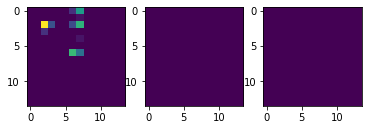

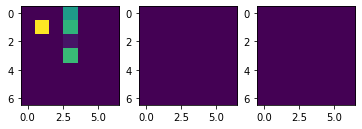

In [59]:
for i in range(0,len(model.layers)-7):
    current_layer_activation = activationsfig[i]
    ns = current_layer_activation.shape[-1]
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    plt.subplot(131)
    plt.imshow(current_layer_activation[0, :, :, 0], cmap='viridis')
    
    ax3 = fig.add_subplot(132)
    plt.subplot(132)
    plt.imshow(current_layer_activation[0, :, :, int(ns/2)], cmap='viridis')
    
    ax5 = fig.add_subplot(133)
    plt.subplot(133)
    plt.imshow(current_layer_activation[0, :, :, ns-1], cmap='viridis')
    

!!! the for loop just for the conv layers... soo after global average layers, there will be amistake!!!!